## Dimensionality Reduction (PCA)
**Problem:** **Multicollinearity**. Medical features are often highly correlated (e.g., Hemoglobin & Hematocrit).
**Solution:** PCA (Principal Component Analysis) creates orthogonal (uncorrelated) components and reduces noise, improving K-Means performance.

## PCA "Inside the Box" (Loadings)
This plot reveals which biological features drive the variance in PC1 and PC2 by showing the strongest loadings (absolute weights).

## Choosing K (Hyperparameter Tuning)
We used the **Elbow Method** to find the optimal number of clusters.
**Decision:** The plot shows an "elbow" around K=3 or K=4. We selected **K=3** based on clinical logic (Stable, Inflammatory, Severe) to ensure interpretable phenotypes.

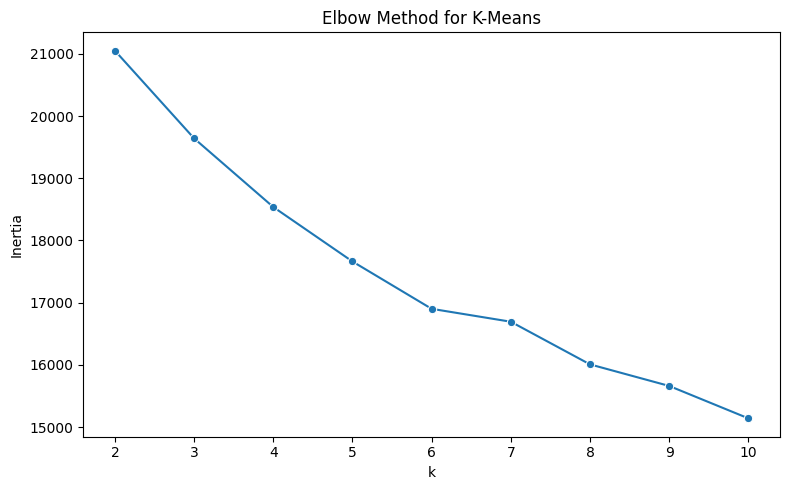

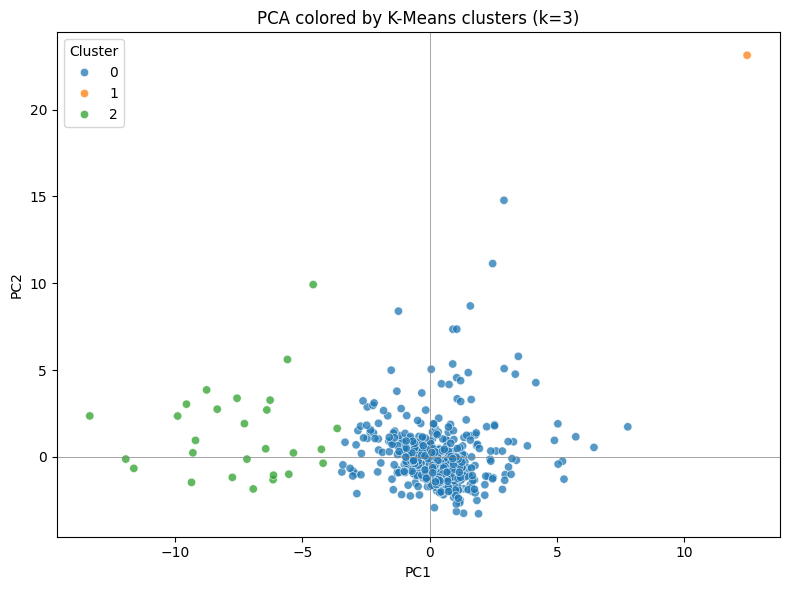

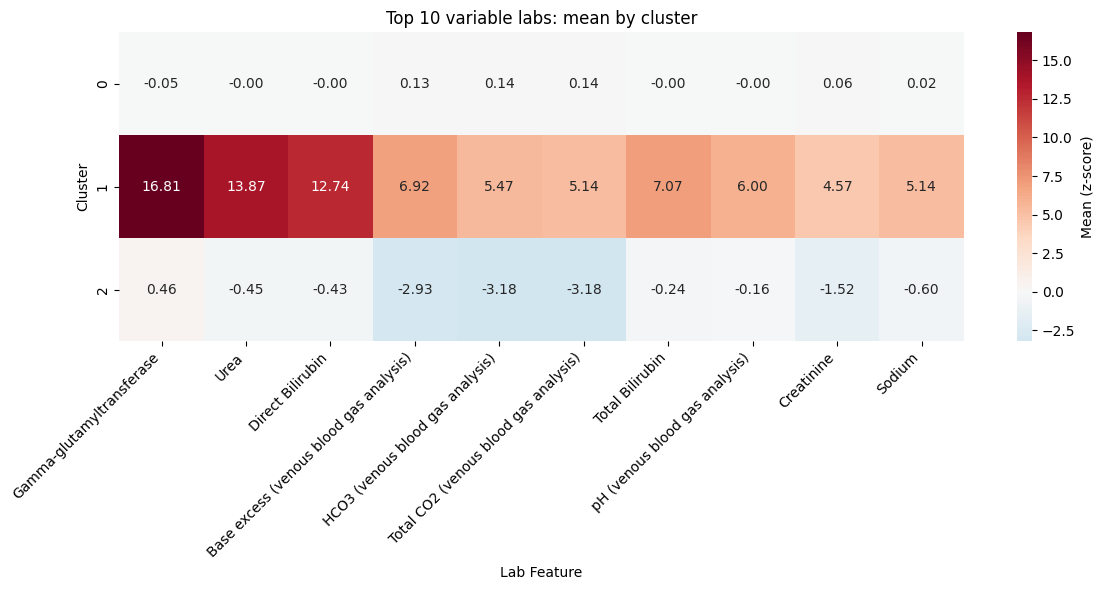

Saved clustered data to ..\data\processed\02_clustered_data.csv
Saved figures to ..\figures


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path

# Paths
IN_PATH = Path("../data/processed/01_cleaned_data.csv")
OUT_PATH = Path("../data/processed/02_clustered_data.csv")
FIG_DIR = Path("../figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load cleaned, already scaled data
df = pd.read_csv(IN_PATH)
if "Patient ID" in df.columns:
    df = df.set_index("Patient ID")

# Targets and features
targets = [
    "SARS-Cov-2 exam result",
    "Patient addmited to regular ward (1=yes, 0=no)",
    "Patient addmited to semi-intensive unit (1=yes, 0=no)",
    "Patient addmited to intensive care unit (1=yes, 0=no)",
]
features = [c for c in df.columns if c not in targets]

X = df[features].values

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df.index)

# PCA loadings (top 10 absolute weights for PC1 and PC2)
loadings = pd.DataFrame(pca.components_.T, index=features, columns=["PC1", "PC2"])
top_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(10).index
top_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(10).index

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(x=loadings.loc[top_pc1, "PC1"], y=top_pc1, ax=axes[0], palette="viridis")
axes[0].set_title("Top 10 PCA loadings (PC1)")
axes[0].set_xlabel("Loading weight")
sns.barplot(x=loadings.loc[top_pc2, "PC2"], y=top_pc2, ax=axes[1], palette="magma")
axes[1].set_title("Top 10 PCA loadings (PC2)")
axes[1].set_xlabel("Loading weight")
plt.tight_layout()
loadings_path = FIG_DIR / "pca_loadings_top10.png"
plt.savefig(loadings_path, dpi=200)
plt.show()

# Elbow method
k_range = range(2, 11)
inertias = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_range), y=inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.xticks(list(k_range))
elbow_path = FIG_DIR / "elbow_kmeans.png"
plt.tight_layout()
plt.savefig(elbow_path, dpi=200)
plt.show()

# KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X)

df_clustered = df.copy()
df_clustered["Cluster"] = clusters
pca_df["Cluster"] = clusters

# Side-by-side: clusters vs SARS-Cov-2 label
sars_col = "SARS-Cov-2 exam result"
if sars_col in df.columns:
    diagnosis = df[sars_col].astype(str).fillna("Unknown")
else:
    diagnosis = pd.Series(["Unknown"] * len(df), index=df.index)
pca_df["Diagnosis"] = diagnosis

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="tab10", alpha=0.75, ax=axes[0])
axes[0].set_title("PCA colored by K-Means clusters")
axes[0].axhline(0, color="gray", linewidth=0.5)
axes[0].axvline(0, color="gray", linewidth=0.5)
axes[0].legend(title="Cluster")

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Diagnosis", palette="Set2", alpha=0.75, ax=axes[1])
axes[1].set_title("PCA colored by SARS-Cov-2 exam result")
axes[1].axhline(0, color="gray", linewidth=0.5)
axes[1].axvline(0, color="gray", linewidth=0.5)
axes[1].legend(title="Diagnosis", loc="best")

plt.tight_layout()
compare_path = FIG_DIR / "pca_clusters_vs_diagnosis.png"
plt.savefig(compare_path, dpi=200)
plt.show()

# Cluster centroids heatmap (z-score features)
centroids = df_clustered.groupby("Cluster")[features].mean()
plt.figure(figsize=(max(10, 0.35 * len(features)), 4 + 0.6 * len(centroids)))
sns.heatmap(centroids, cmap="RdBu_r", center=0, cbar_kws={"label": "Mean (z-score)"})
plt.title("Cluster centroids (mean z-scores)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.xticks(rotation=90)
heatmap_path = FIG_DIR / "heatmap_cluster_centroids.png"
plt.tight_layout()
plt.savefig(heatmap_path, dpi=200)
plt.show()

# Save clustered data
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df_clustered.to_csv(OUT_PATH, index=False)
print(f"Saved clustered data to {OUT_PATH}")
print(f"Saved figures to {FIG_DIR}")


### Phenotype interpretation (post-heatmap)
- Use the centroid heatmap (red = high, blue = low) to label clusters.
- Example interpretation pattern:
  - Cluster with high CRP/Leukocytes → **Inflammatory**
  - Cluster with high Urea/Creatinine (± other metabolic markers) → **Multi-System Failure**
  - Cluster with values near 0 across markers → **Stable**
- Centroids are shown in z-scores to emphasize relative highs/lows across labs.
- Figure saved to `../figures/heatmap_cluster_centroids.png`.
